# 자료 확인

In [13]:
import pandas as pd
df = pd.read_csv('train_1722.csv', encoding='cp949')
df.head()

,pid,year,month,day,weight,quantity,value
0,P001,2017,1,10,64893,100,786047
1,P001,2017,1,20,24506,2357,282998
2,P001,2017,1,30,7930,247,596801
3,P001,2017,2,10,5107,2206,766565
4,P001,2017,2,20,54188,1662,1791564


In [17]:
df.shape

(1080, 7)

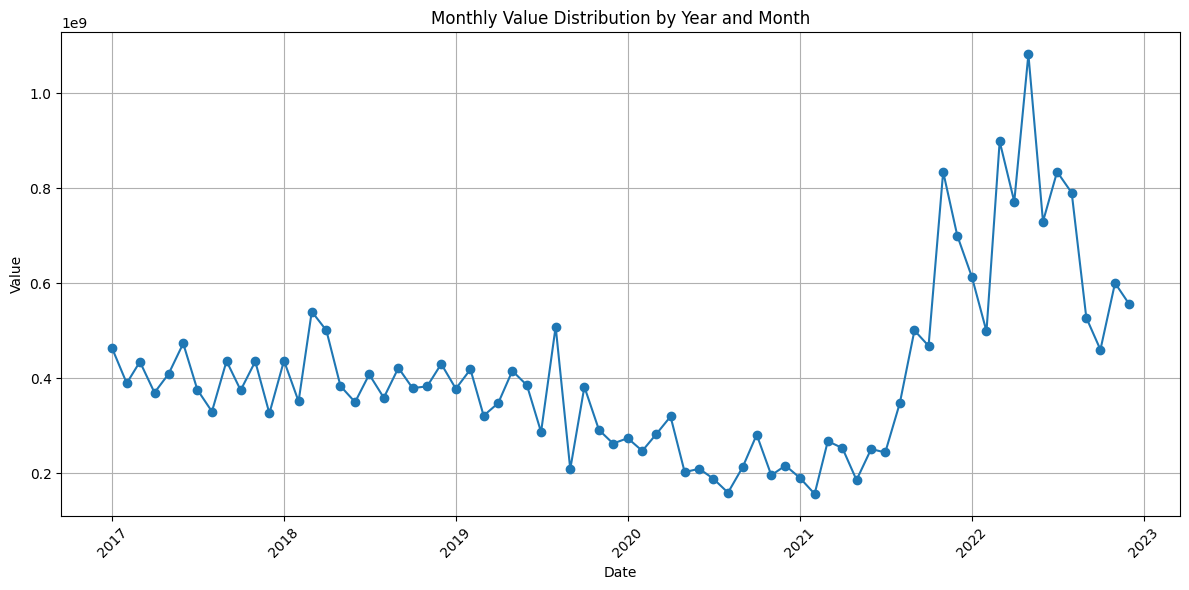

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 읽기
df = pd.read_csv('train_1722.csv', encoding='cp949')

# 연도(year)와 월(month) 기준으로 value 합계 계산
monthly_value = df.groupby(['year', 'month'])['value'].sum().reset_index()

# 날짜 생성: year와 month를 결합하여 새로운 datetime 컬럼 생성
monthly_value['date'] = pd.to_datetime(monthly_value[['year', 'month']].assign(day=1))

# 시계열 그림 그리기
plt.figure(figsize=(12, 6))
plt.plot(monthly_value['date'], monthly_value['value'], marker='o')
plt.title('Monthly Value Distribution by Year and Month')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


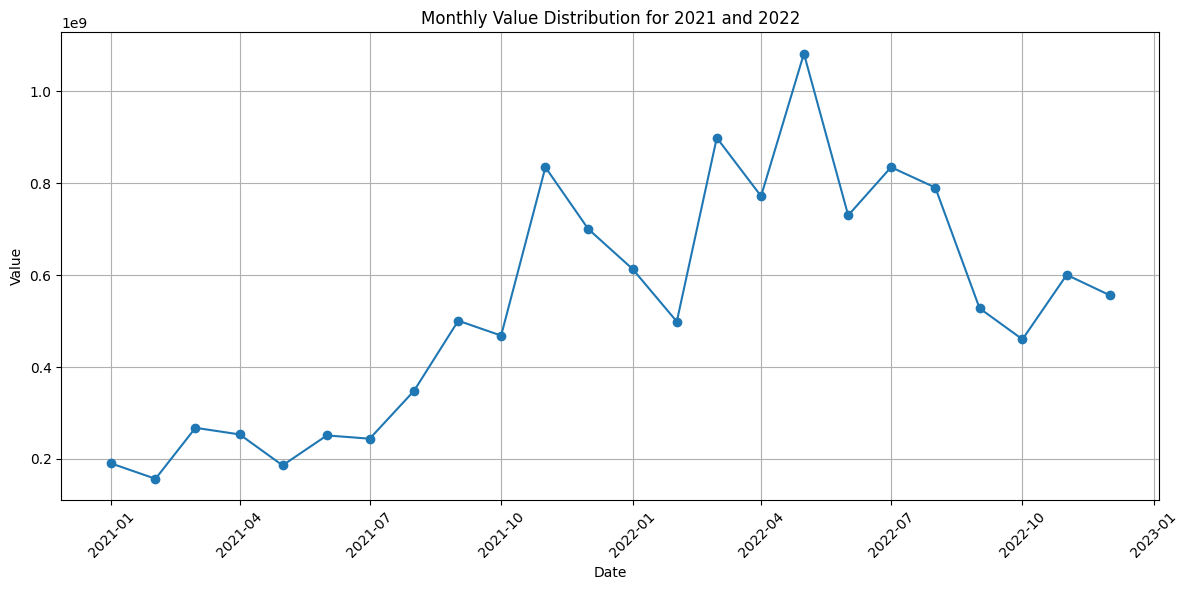

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 읽기
df = pd.read_csv('train_1722.csv', encoding='cp949')

# 연도(year)와 월(month) 기준으로 value 합계 계산
monthly_value = df.groupby(['year', 'month'])['value'].sum().reset_index()

# year가 2021 또는 2022인 값만 필터링
monthly_value = monthly_value[monthly_value['year'].isin([2021, 2022])]

# 날짜 생성: year와 month를 결합하여 새로운 datetime 컬럼 생성
monthly_value['date'] = pd.to_datetime(monthly_value[['year', 'month']].assign(day=1))

# 시계열 그림 그리기
plt.figure(figsize=(12, 6))
plt.plot(monthly_value['date'], monthly_value['value'], marker='o')
plt.title('Monthly Value Distribution for 2021 and 2022')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


- 2017~2019 의 value 는 나름 비슷한 형태
- 2020.01 ~ 2021.02 는 하향
- 2021.02 ~ 2021.11 는 상향
- 2021.11 ~ 2022.12 는 이상함

### 변수 확인

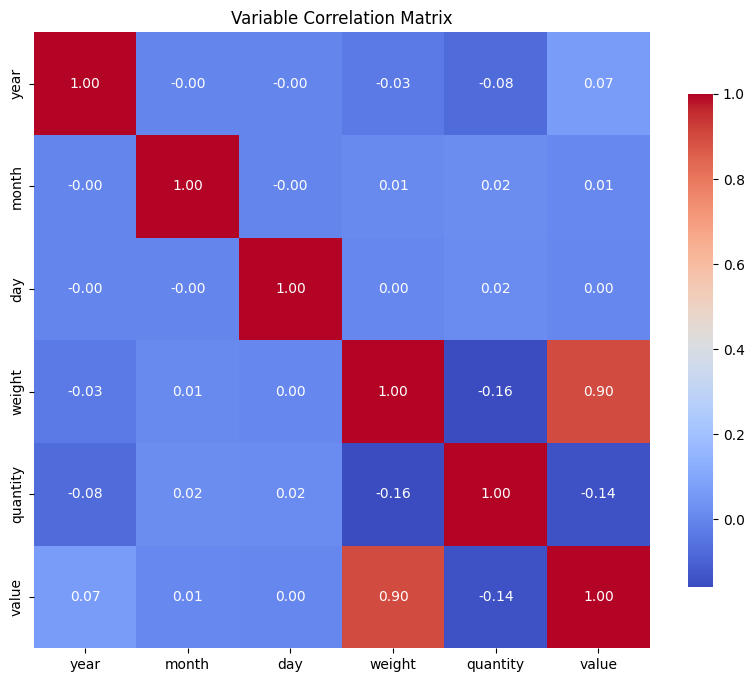

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 읽기
df = pd.read_csv('train_1722.csv', encoding='cp949')

# 수치형 변수만 선택하여 상관 행렬 계산
correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

# 상관 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Variable Correlation Matrix')
plt.show()


- 표본상관계수를 확인해보면 weigh와 value 값이 상관관계가 높은 것으로 확인됨

## 회귀분석

### 2017.01~ 2022.12 데이터 활용
- 상관관계가 좋은 weight 변수만 사용

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 읽기
df = pd.read_csv('train_1722.csv', encoding='cp949')

# 독립 변수(X)와 종속 변수(y) 설정 (weight만 사용)
X = df[['weight']]  # 독립 변수
y = df['value']     # 종속 변수

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀 모델 생성
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 결과 출력
print("회귀 계수:", model.coef_)
print("절편:", model.intercept_)
print("평균 제곱 오차 (MSE):", mean_squared_error(y_test, y_pred))
print("루트 평균 제곱 오차 (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("결정 계수 (R^2):", r2_score(y_test, y_pred))


회귀 계수: [0.19437325]
절편: 1239380.3085846193
평균 제곱 오차 (MSE): 887326873024374.1
루트 평균 제곱 오차 (RMSE): 29788032.37920179
결정 계수 (R^2): 0.772463759445637


# 2019 -2020년 데이터 활용
- 값이 0인 quantity 값 제외

### 2019, 2020년 day 기준으로 시계열 자료 분석

In [35]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------  9.7/9.8 MB 60.5 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 47.1 MB/s eta 0:00:00


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 데이터 읽기
df = pd.read_csv('train_1722.csv', encoding='cp949')

# year가 2019 또는 2020인 데이터 필터링
df_filtered = df[(df['year'] == 2019) | (df['year'] == 2020)]

# month 기준으로 value 합계 계산
monthly_value = df_filtered.groupby(['year', 'month'])['value'].sum().reset_index()

# 월별 데이터를 시계열로 변환
ssec2 = monthly_value['value'].values
ssec_ts = pd.Series(ssec2, index=pd.date_range(start='2019-01-01', periods=len(ssec2), freq='M'))


# 독립 변수 생성
tt = np.arange(1, len(ssec_ts) + 1)

# 1차 회귀 분석
X1 = sm.add_constant(tt)  # 상수항 추가
reg1 = sm.OLS(ssec_ts, X1).fit()  # OLS 회귀 분석
# print(reg1.summary())

# 2차 회귀 분석
X2 = sm.add_constant(np.column_stack((tt, tt**2)))  # 1차, 2차 항 추가
reg2 = sm.OLS(ssec_ts, X2).fit()  # OLS 회귀 분석
print(reg2.summary())

# 로그 변환 후 회귀 분석
log_ssec_ts = np.log(ssec_ts)
reg3 = sm.OLS(log_ssec_ts, X1).fit()  # OLS 회귀 분석
# print(reg3.summary())

# 잔차 제곱합 비교
sse1 = np.sum(reg1.resid**2)
sse2 = np.sum(reg2.resid**2)
sse3 = np.sum((ssec_ts - np.exp(reg3.fittedvalues))**2)
print(sse1, sse2, sse3)

# # 최솟값 인덱스 찾기
# min_sse_index = np.argmin([sse1, sse2, sse3])
# print("Minimum SSE index:", min_sse_index)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     12.56
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           0.000258
Time:                        01:10:51   Log-Likelihood:                -463.39
No. Observations:                  24   AIC:                             932.8
Df Residuals:                      21   BIC:                             936.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.174e+08   4.19e+07      9.957      0.0

C:\Users\USER-PC\AppData\Local\Temp\ipykernel_13496\816084017.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ssec_ts = pd.Series(ssec2, index=pd.date_range(start='2019-01-01', periods=len(ssec2), freq='M'))


- 2차식 적합한 모형이 설명력 좋음

### 가변수 추가

In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'ssec_ts' is already defined
# Create independent variable (tt)
tt = np.arange(1, len(ssec_ts) + 1)

# Create dummy variables for each month
Q1 = (tt % 12) == 1
Q2 = (tt % 12) == 2
Q3 = (tt % 12) == 3
Q4 = (tt % 12) == 4
Q5 = (tt % 12) == 5
Q6 = (tt % 12) == 6
Q7 = (tt % 12) == 7
Q8 = (tt % 12) == 8
Q9 = (tt % 12) == 9
Q10 = (tt % 12) == 10
Q11 = (tt % 12) == 11

# Combine dummy variables into a DataFrame
dummy_vars = pd.DataFrame({
    'Q1': Q1.astype(int),
    'Q2': Q2.astype(int),
    'Q3': Q3.astype(int),
    'Q4': Q4.astype(int),
    'Q5': Q5.astype(int),
    'Q6': Q6.astype(int),
    'Q7': Q7.astype(int),
    'Q8': Q8.astype(int),
    'Q9': Q9.astype(int),
    'Q10': Q10.astype(int),
    'Q11': Q11.astype(int),
})

# Create the dependent variable
ssec_ts = np.array(ssec_ts)  # Ensure it's a NumPy array if it's not already

# Create the independent variable DataFrame
X = pd.DataFrame({'tt': tt, 'tt_squared': tt**2})
X = pd.concat([X, dummy_vars], axis=1)

# Add a constant term for the intercept
X = sm.add_constant(X)

# OLS regression
reg4 = sm.OLS(ssec_ts, X).fit()

# Summary of the regression
print(reg4.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     1.937
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.150
Time:                        01:10:24   Log-Likelihood:                -457.74
No. Observations:                  24   AIC:                             943.5
Df Residuals:                      10   BIC:                             960.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.264e+08   7.45e+07      5.726      0.0